# COPD Detection with CNNs
---


## 1. Setup the dataset

### Downloading the dataset
Download the dataset from kaggle using apikey.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a kaggle.json file with the credentials.
!mkdir /root/.kaggle

!touch /root/.kaggle/kaggle.json

!echo '{"username":"arpansrivastav","key":"b9de0b7324218cb69d2ff3fdc168f04b"}' > /root/.kaggle/kaggle.json

!chmod 600 /root/.kaggle/kaggle.json
 
# Download the dataset using the kaggle api.
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.68G/3.69G [01:03<00:00, 42.2MB/s]
100% 3.69G/3.69G [01:03<00:00, 62.0MB/s]


### Unzip the dataset
Unzip the dataset using shell command `unzip`.

In [ ]:
# Unzip the dataset
!unzip respiratory-sound-database.zip 'respiratory_sound_database/Respiratory_Sound_Database/*' -d 'drive/My Drive/CNN_Detection/respiratory_sound_dataset'

In [ ]:
import os

if not os.path.exists('dataset'):
    os.makedirs('dataset')

# Copy everything to the root dir so as to avoid confusion
!cp -r drive/My\ Drive/CNN_Detection/respiratory_sound_dataset/respiratory_sound_database/Respiratory_Sound_Database/* dataset/

# Delete remaining empty folders
# !rm -rf dataset/respiratory_sound_database

^C


## 2. Preprocess the data
---

### Import necessary libraries

In [ ]:
# Install nlpaug
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv

# Basic python imports
import os
import shutil
from shutil import copy2
from random import randrange
from datetime import datetime

# Extra data types :o
import numpy as np
import pandas as pd
import IPython.display as ipd

# Librosa to load the 'wav' files
import librosa
import librosa.display

# Graphs
import matplotlib.pyplot as plt

# Actual thekedaars
from scipy.io.wavfile import read
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold

# Augmentors
import nlpaug.augmenter.audio as naa
import nlpaug.flow as naf

# To display progress
# from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

# Constants (Do not change)
__GENERATE__FRESH__ = "__GENERATE__FRESH__"
__LOAD__UPLOADED__ = "__LOAD__UPLOADED__"

# Useful util functions
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


#################################################################################################################
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

#imports
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1
#

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    #print ('\ndf_cm:\n', df_cm, '\n\b\n')
#

def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#

def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
    

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-ojl3nmm0
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-ojl3nmm0
  Created wheel for nlpaug: filename=nlpaug-1.1.0-cp36-none-any.whl size=823805 sha256=42c76b00f56738510ecc6d0cc95dfef10d632192be56d3b5bfd552dae66b1b40
  Stored in directory: /tmp/pip-ephem-wheel-cache-gqdvdnyo/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


## SpecAugmentation Code

### Initialize base variables

In [ ]:
# Base directory for the dataset
dataset_dir = 'drive/My Drive/CNN_Detection/respiratory_sound_dataset/respiratory_sound_database/Respiratory_Sound_Database/'

base_dir = os.path.join(os.getcwd(), dataset_dir)

# Path to the main csv file
path_to_csv = os.path.join(base_dir, 'patient_diagnosis.csv')

### Load the classification data

In [ ]:
classification_data = pd.read_csv(path_to_csv, names=['patient_id', 'condition'])

# Change all fields except 'COPD' as 'non-COPD'
classification_data['condition'] = classification_data['condition'].apply(lambda x: 'non-COPD' if x != 'COPD' else 'COPD')
 
# Print the dataset
classification_data

,patient_id,condition
0,101,non-COPD
1,102,non-COPD
2,103,non-COPD
3,104,COPD
4,105,non-COPD
...,...,...
121,222,COPD
122,223,COPD
123,224,non-COPD
124,225,non-COPD


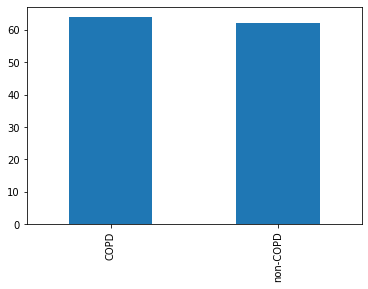

In [ ]:
classification_data['condition'].value_counts().plot(kind='bar')

### Extract features from audio

Load required features from the audio files and save the data in `audio_details_df`.

Currently extracting: `mfcc` and `melspectrogram`.

In [ ]:
# Max duration (in seconds) to consider a file
THRESHOLD_DURATION = 60

# Duration (in seconds) to pad or trim the file
FIX_AUDIO_LENGTH = 20

# Filename to load (if loading from disk)
AUDIO_DETAILS_DF_FILENAME_TEMPLATE = 'drive/My Drive/CNN_Detection/audio_details_{}.npy'

# Check to print DEBUG Logs
DEBUG = True

# Augment data (If generating new)
augment = True

default_sample_rate = 22050

# Augmentors variables
loud_aug_min, loud_aug_max = 0.6, 1.4
speed_aug_min, speed_aug_max = 0.5, 2

# Load or Create new
# CHANGE HERE TO LOAD FROM UPLOADED CSV OR TO GENERATE FRESH FEATURES
MODE = __LOAD__UPLOADED__
# MODE = __GENERATE__FRESH__

In [ ]:
audio_details_df = None

# Define Augmentors
loud_aug = naa.LoudnessAug(factor=(loud_aug_min, loud_aug_max))
mask_aug = naa.MaskAug(sampling_rate=default_sample_rate, mask_with_noise=False)
shift_aug = naa.ShiftAug(sampling_rate=default_sample_rate)
speed_aug = naa.SpeedAug(factor=(speed_aug_min, speed_aug_max))

# Function to extract details from a file_name
def extract_from_file_name(file_name, index):
    base_file_name = os.path.splitext(file_name)[0]
    features = base_file_name.split('_')
    return features[index]

def load_audios(audio_location):
    audio_paths = []

    for content_file in os.listdir(audio_location):
        if 'wav' in content_file:
            audio_paths.append(content_file)

    print("{} audio files found.".format(len(audio_paths)))

    return audio_paths

def extract_features(series, n_count=40, augmented=False):
    if augmented:
        if len(series) < THRESHOLD_DURATION * sample_rate:
            print("Augmented Series: OMIT: Length = {} seconds".format(len(series) / sample_rate))
            return

    # Consider files less than threshold value
    if len(series) < THRESHOLD_DURATION * sample_rate:

        # Make every series the same length
        series = librosa.util.fix_length(series, size = FIX_AUDIO_LENGTH * sample_rate)

        # Duration of audio = no. of samples / sample_rate
        length = len(series)/float(sample_rate)

        # print("Progress: {}/{} (Omitted: {}) | {}\nSeries_Length = {} | sample_rate = {} | Audio Length: {}".format(count + omitted, len(audio_paths), omitted, clip, len(series), sample_rate, length))
        
        # TODO: Use the features 
        mfcc = librosa.feature.mfcc(y=series, n_mfcc=n_count)
        mel = librosa.feature.melspectrogram(y=series, n_mels=n_count)
        c_stft = librosa.feature.chroma_stft(y=series, n_chroma=n_count)
        c_cqt = librosa.feature.chroma_cqt(y=series, n_chroma=n_count)
        c_cens = librosa.feature.chroma_cens(y=series, n_chroma=n_count)

        return mfcc, mel, c_stft, c_cqt, c_cens
        

def audio_augment(series):
    loud_out = loud_aug.augment(series)
    # print("AUG: Loudness.")

    mask_out = mask_aug.augment(series)
    # print("AUG: Mask.")

    shift_out = shift_aug.augment(series)
    # print("AUG: Shift.")

    speed_out = speed_aug.augment(series)
    # print("AUG: Speed.")

    return loud_out, mask_out, shift_out, speed_out

    
def get_condition_from_id(patient_id, data=classification_data):
    return data.query('patient_id == @patient_id')['condition'].values[0]

In [ ]:
suffix = ""
if augment == True:
    suffix = suffix + "aug"
else:
    suffix = suffix + "noaug"

extra_suffix = ""

if extra_suffix != "":
    suffix = suffix + extra_suffix

AUDIO_DETAILS_DF_FILENAME = AUDIO_DETAILS_DF_FILENAME_TEMPLATE.format(suffix)

# Print the path
print(AUDIO_DETAILS_DF_FILENAME)

# Check if the path exists
if os.path.exists(AUDIO_DETAILS_DF_FILENAME):
    print("Path exists.")
else:
    print("WARNING: Path is invalid or wrong Drive mounted.")

print("Mode =", MODE)

drive/My Drive/CNN_Detection/audio_details_aug.npy
Path exists.
Mode = __LOAD__UPLOADED__


In [ ]:
# if os.path.exists(AUDIO_DETAILS_DF_FILENAME):
#     MODE = __LOAD__UPLOADED__
# else:
#     MODE = __GENERATE__FRESH__

audio_data = []
audio_lengths = {}

audio_details_df = None

if MODE == __GENERATE__FRESH__:
    print("Generating fresh audio_details_df...")
    print("Will be saving to : {}".format(AUDIO_DETAILS_DF_FILENAME))

    # Read data from the music folders.
    audio_location = os.path.join(base_dir, 'audio_and_txt_files')

    # Array to store the name of the 'wav' files
    audio_paths = load_audios(audio_location)

    # Create a progress bar
    progress_clips = tqdm(audio_paths, total=len(audio_paths), desc="Processing Audio tracks (omitted: 0, aug: 0, total_processed: 0, copd_skips: 0)", ncols='90%')

    # np array to store the file names and their lengths

    count = 0
    omitted = 0
    augment_count = 0
    copd_skips = 0
    total = len(audio_paths) * 4 if augment else len(audio_paths)


    # Get the length of the audio clips into an array
    for clip in progress_clips:

        clip_path = os.path.join(audio_location, clip)

        # Load file using librosa
        series, sample_rate = librosa.load(clip_path, res_type='kaiser_fast')

        # Use only wav files and not txt
        try:
            # Extract 5 features
            mfcc, mel, c_stft, c_cqt, c_cens = extract_features(series)

            # Append the data to the list
            audio_lengths[count] = {
                'audio_series': series,
                'file_name': clip,
                # 'length': length,
                'mfcc': mfcc,
                'melspectrogram': mel,
                'chroma_stft': c_stft,
                'chroma_cqt':c_cqt,
                'chroma_cens': c_cens,
                'augmented': False
            }

            count = count + 1

            if augment == False:
                continue

            patient_id = extract_from_file_name(clip, 0)

            patient_condition = get_condition_from_id(patient_id)

            # Augment if non-copd
            
            
            if patient_condition == 'non-COPD':
                # print("Augmenting....")

                # Aug outputs
                aug_outs = []

                # print("Before calling audio_augment()")

                # Perform aug
                aug_outs = audio_augment(series)

                # print("After calling audio_augment()")


                # print("Aug'ed -> {}".format(aug_outs))

                # Then extract
                for aug_out in tqdm(aug_outs, total=len(aug_outs), desc="Augmentation Progress", leave=False):
                    # print("Extracting aug'ed features......")

                    # mfcc, mel, c_stft, c_cqt, c_cens = extract_features(aug_out)

                    audio_lengths[count] = {
                        'audio_series': series,
                        'file_name': clip,
                        'mfcc': mfcc,
                        'melspectrogram': mel,
                        'chroma_stft': c_stft,
                        'chroma_cqt':c_cqt,
                        'chroma_cens': c_cens,
                        'augmented': True
                    }

                    count = count + 1

                    augment_count = augment_count + 1
            else:
                copd_skips = copd_skips + 1

                count = count + 4

            # if count > 100:
            #     break

            # progress_clips.set_description("Processing Audio tracks (omitted: {}, aug: {})".format(omitted, augment_count))

        # TypeError if the function returns None.
        except TypeError as e:
            if DEBUG:
                print(e)

            # print("\nOMIT: Omitting {} since duration ({}) > {}s".format(clip, len(series)/float(sample_rate), THRESHOLD_DURATION))
            omitted = omitted + 1

            # Update progress bar description
            # progress_clips.set_description("Processing Audio tracks (omitted: {}, aug: {})".format(omitted, augment_count))

        progress_clips.set_description("Processing Audio tracks (omitted: {}, aug: {}, copd_skips: {}, total_processed: {}/{})".format(omitted, augment_count, copd_skips, augment_count + count, total))


    # Save to file for loading baadmeh
    print("Saving to disk at {}...".format(AUDIO_DETAILS_DF_FILENAME))
    np.save(AUDIO_DETAILS_DF_FILENAME, audio_lengths)

    audio_details_df = pd.DataFrame(audio_lengths).T


elif MODE == __LOAD__UPLOADED__:

    # if not os.path.exists('audio_details.npy'):
    #     print("Copying file from drive...")
    #     !cp "{AUDIO_DETAILS_DF_FILENAME}" .

    print("Loading {}...".format(AUDIO_DETAILS_DF_FILENAME))
    # Read the audio_details.csv
    audio_lengths = np.load(AUDIO_DETAILS_DF_FILENAME, allow_pickle=True).item()

    # Create dataframe from audio_lengths
    audio_details_df = pd.DataFrame(audio_lengths).T

    # Convert columns to numeric
    for k in list(audio_details_df):
        audio_details_df[k]=pd.to_numeric(audio_details_df[k], errors='ignore')

    print()
    print(audio_details_df.dtypes)
    
else:
    raise Exception("Please select MODE = __LOAD__UPLOADED__ or MODE = __GENERATE__FRESH__.")


# _apply_ function on file_name to extract patient_id
audio_details_df['patient_id'] = audio_details_df['file_name'].apply(extract_from_file_name, args=(0,)).astype(np.int64)

# _apply_ function on file_name to extract rec_instrument
audio_details_df['rec_instrument'] = audio_details_df['file_name'].apply(extract_from_file_name, args=(4,))

print(audio_details_df.dtypes)

Loading drive/My Drive/CNN_Detection/audio_details_aug.npy...

audio_series      object
file_name         object
mfcc              object
melspectrogram    object
chroma_stft       object
chroma_cqt        object
chroma_cens       object
augmented           bool
dtype: object
audio_series      object
file_name         object
mfcc              object
melspectrogram    object
chroma_stft       object
chroma_cqt        object
chroma_cens       object
augmented           bool
patient_id         int64
rec_instrument    object
dtype: object


In [ ]:
    len(audio_lengths)

1403

In [ ]:
audio_details_df.dtypes

# # Check if audio_details_df has initialized
# if audio_details_df is not None:
#     audio_details_df['patient_id'] = pd.to_numeric(audio_details_df['patient_id'])

#     print(audio_details_df)
#     print(audio_details_df.dtypes)

# else:
#     raise Exception("type(audio_details_df) = {}".format(type(audio_details_df)))

audio_series      object
file_name         object
mfcc              object
melspectrogram    object
chroma_stft       object
chroma_cqt        object
chroma_cens       object
augmented           bool
patient_id         int64
rec_instrument    object
dtype: object

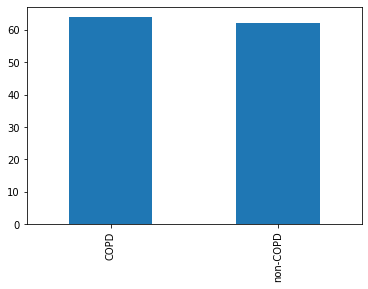

In [ ]:
classification_data['condition'].value_counts().plot(kind='bar')

# Split the data

### Visualize features

Currently plotting `mfcc` and `melspectrogram`.

In [ ]:
# Index of the observation to plot the mfcc and melspectrograms.
# Either provide an index or set it to a random int.
index = randrange(56)

# Extract the name of the file to plot
file_name_to_plot = audio_details_df['file_name'][index]

# Find a non augmented and an augmented row
non_augmented_row = audio_details_df.query('file_name == @file_name_to_plot & augmented == False')
augmented_row = audio_details_df.query('file_name == @file_name_to_plot & augmented == True').head(1)

print(non_augmented_row.head())
print(augmented_row.head())

print(file_name_to_plot)

# MFCC
for row in [non_augmented_row, augmented_row]:
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(row['mfcc'], x_axis='time', y_axis='')
    plt.colorbar()
    plt.title('MFCC - {}'.format(file_name_to_plot))
    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.cla()
    plt.close('all')  

    # Chroma_STFT plot
    for chroma_type in ['chroma_stft', 'chroma_cqt', 'chroma_cens']:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(audio_details_df[chroma_type][index], y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.title('{} - {}'.format(chroma_type, file_name_to_plot))
        plt.tight_layout()
        plt.show()
        plt.clf()
        plt.cla()
        plt.close('all')  

    # --- MFCC plot ---
    # plt.figure(figsize=(10, 4))
    # librosa.display.specshow(audio_details_df['mfcc'][index], x_axis='time')
    # plt.colorbar()
    # plt.title('MFCC - {}'.format(file_name_to_plot))
    # plt.tight_layout()
    # plt.show()
    # plt.clf()
    # plt.cla()
    # plt.close('all')  


    # --- Mel-Spectrogram plot ---
    plt.figure(figsize=(10, 4))

    # Transform melspectrogram values using power_to_db
    S_dB = librosa.power_to_db(audio_details_df['melspectrogram'][index], ref=np.max)

    # Plot the values in a graph
    librosa.display.specshow(S_dB, x_axis='time',
                            y_axis='mel',)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram - {}'.format(file_name_to_plot))
    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.cla()
    plt.close('all')  

    ## AUGMENT

    # plt.figure(figsize=(10, 4))

    # # Transform melspectrogram values using power_to_db
    # augmented_mel = augment(audio_details_df['melspectrogram'][index])

    # # Plot the values in a graph
    # librosa.display.specshow(augmented_mel, x_axis='time',
    #                          y_axis='mel',)
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Augmented Mel-frequency spectrogram - {}'.format(file_name_to_plot))
    # plt.tight_layout()
    # plt.show()
    # plt.clf()
    # plt.cla()
    # plt.close('all') 

                                        audio_series  ... rec_instrument
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...       AKGC417L

[1 rows x 10 columns]
Empty DataFrame
Columns: [audio_series, file_name, mfcc, melspectrogram, chroma_stft, chroma_cqt, chroma_cens, augmented, patient_id, rec_instrument]
Index: []
160_1b3_Al_mc_AKGC417L.wav


TypeError: ignored

<Figure size 720x288 with 0 Axes>

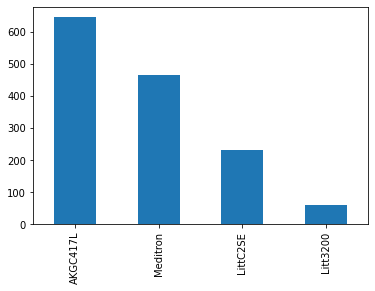

In [ ]:
# Plot the frequency of the instruments used
audio_details_df['rec_instrument'].value_counts().plot(kind='bar')

### Merge `audio_details_df` with `classification_data`
We merge on the basis of `patient_id` and add the disease column in the dataset.

In [ ]:
features = audio_details_df.merge(classification_data, left_on='patient_id', right_on='patient_id')

features

,audio_series,file_name,mfcc,melspectrogram,chroma_stft,chroma_cqt,chroma_cens,augmented,patient_id,rec_instrument,condition
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",160_1b3_Al_mc_AKGC417L.wav,"[[-450.92580566276166, -450.92580566276166, -4...","[[0.0, 0.0, 1.3067699839907195e-19, 0.20064224...","[[0.0, 0.0, 0.036249917938060754, 0.8084153958...","[[0.16888623683528456, 0.17711006586011097, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,160,AKGC417L,COPD
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",160_1b3_Ar_mc_AKGC417L.wav,"[[-442.08650642266167, -442.08650642266167, -4...","[[0.0, 0.0, 2.9241007719414696e-17, 110.125166...","[[0.0, 0.0, 0.035744991010577945, 0.9579850287...","[[0.5262072612309953, 0.5313929305356073, 0.54...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,160,AKGC417L,COPD
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",160_1b3_Lr_mc_AKGC417L.wav,"[[-425.88091161002507, -425.88091161002507, -4...","[[0.0, 0.0, 8.822594697743669e-18, 46.35237656...","[[0.0, 0.0, 0.03574689062122756, 0.95656234066...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.8877997822962096, 0.8993795749493307, 0.91...",False,160,AKGC417L,COPD
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",160_1b3_Tc_mc_AKGC417L.wav,"[[-424.45705066967236, -424.45705066967236, -4...","[[0.0, 0.0, 1.3344257370018375e-17, 30.6025907...","[[0.0, 0.0, 0.02908382666558372, 0.93804389729...","[[0.40412200818280486, 0.4081601618920803, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,160,AKGC417L,COPD
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",160_1b3_Pr_mc_AKGC417L.wav,"[[-525.8411476233618, -525.8411476233618, -525...","[[0.0, 0.0, 1.578317671219404e-20, 1.410641654...","[[0.0, 0.0, 0.03671304821645207, 0.73842522119...","[[0.45680979189280085, 0.46036510126407076, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00019359738454189...",False,160,AKGC417L,COPD
...,...,...,...,...,...,...,...,...,...,...,...
1398,"[-0.022489991, -0.035103686, -0.03046739, -0.0...",159_1b1_Pr_sc_Meditron.wav,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",False,159,Meditron,non-COPD
1399,"[-0.022489991, -0.035103686, -0.03046739, -0.0...",159_1b1_Pr_sc_Meditron.wav,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",True,159,Meditron,non-COPD
1400,"[-0.022489991, -0.035103686, -0.03046739, -0.0...",159_1b1_Pr_sc_Meditron.wav,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",True,159,Meditron,non-COPD
1401,"[-0.022489991, -0.035103686, -0.03046739, -0.0...",159_1b1_Pr_sc_Meditron.wav,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",True,159,Meditron,non-COPD


In [ ]:
# augmented_COPD = features[(features.augmented == True) & (features.condition == 'COPD')]

# # augmented_COPD.head()

# features_backup = features

# features = features.drop(features[(features.augmented == True) & (features.condition == 'COPD')].index)

# print(features.shape)
# print(features_backup.shape)

In [ ]:
# Remove unneccessary columns
del features['patient_id']
# del features['file_name']
del features['rec_instrument']
del features['audio_series']

# TODO: Check if we need to do anything with augmented col.
del features['augmented']

features

,file_name,mfcc,melspectrogram,chroma_stft,chroma_cqt,chroma_cens,condition
0,160_1b3_Al_mc_AKGC417L.wav,"[[-450.92580566276166, -450.92580566276166, -4...","[[0.0, 0.0, 1.3067699839907195e-19, 0.20064224...","[[0.0, 0.0, 0.036249917938060754, 0.8084153958...","[[0.16888623683528456, 0.17711006586011097, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",COPD
1,160_1b3_Ar_mc_AKGC417L.wav,"[[-442.08650642266167, -442.08650642266167, -4...","[[0.0, 0.0, 2.9241007719414696e-17, 110.125166...","[[0.0, 0.0, 0.035744991010577945, 0.9579850287...","[[0.5262072612309953, 0.5313929305356073, 0.54...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",COPD
2,160_1b3_Lr_mc_AKGC417L.wav,"[[-425.88091161002507, -425.88091161002507, -4...","[[0.0, 0.0, 8.822594697743669e-18, 46.35237656...","[[0.0, 0.0, 0.03574689062122756, 0.95656234066...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.8877997822962096, 0.8993795749493307, 0.91...",COPD
3,160_1b3_Tc_mc_AKGC417L.wav,"[[-424.45705066967236, -424.45705066967236, -4...","[[0.0, 0.0, 1.3344257370018375e-17, 30.6025907...","[[0.0, 0.0, 0.02908382666558372, 0.93804389729...","[[0.40412200818280486, 0.4081601618920803, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",COPD
4,160_1b3_Pr_mc_AKGC417L.wav,"[[-525.8411476233618, -525.8411476233618, -525...","[[0.0, 0.0, 1.578317671219404e-20, 1.410641654...","[[0.0, 0.0, 0.03671304821645207, 0.73842522119...","[[0.45680979189280085, 0.46036510126407076, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00019359738454189...",COPD
...,...,...,...,...,...,...,...
1398,159_1b1_Pr_sc_Meditron.wav,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD
1399,159_1b1_Pr_sc_Meditron.wav,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD
1400,159_1b1_Pr_sc_Meditron.wav,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD
1401,159_1b1_Pr_sc_Meditron.wav,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD


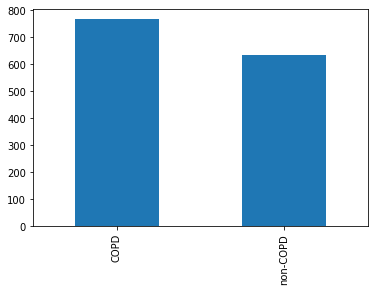

In [ ]:
features['condition'].value_counts().plot(kind='bar')

### Split the data into train and test sets according to ICBHI Competition[link text](https://)

In [ ]:
# Get train-test split data from official ICBHI Competition
if not os.path.exists('ICBHI_challenge_train_test.txt'):
    !wget https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/ICBHI_challenge_train_test.txt --no-check-certificate

file_names = []
dataset_type = []

with open('ICBHI_challenge_train_test.txt') as data:
    for line in data:
        file_name = line.split()[0]
        data_type = line.split()[1]

        file_names.append(file_name)
        dataset_type.append(data_type)


splits_df = pd.DataFrame({'file_name': file_names, 'dataset': dataset_type})

splits_df         

,file_name,dataset
0,101_1b1_Al_sc_Meditron,test
1,101_1b1_Pr_sc_Meditron,test
2,102_1b1_Ar_sc_Meditron,test
3,103_2b2_Ar_mc_LittC2SE,train
4,104_1b1_Al_sc_Litt3200,test
...,...,...
915,224_1b2_Al_sc_Meditron,test
916,225_1b1_Pl_sc_Meditron,test
917,226_1b1_Al_sc_Meditron,train
918,226_1b1_Ll_sc_Meditron,train


In [ ]:
# Merge audio_details_df with splits_df to understand which test and which train
features['file_name'] = features['file_name'].apply(lambda x: x.strip().split('.')[0])

features = features.merge(splits_df, how='inner', left_on='file_name', right_on='file_name')

features

,file_name,mfcc,melspectrogram,chroma_stft,chroma_cqt,chroma_cens,condition,dataset
0,160_1b3_Al_mc_AKGC417L,"[[-450.92580566276166, -450.92580566276166, -4...","[[0.0, 0.0, 1.3067699839907195e-19, 0.20064224...","[[0.0, 0.0, 0.036249917938060754, 0.8084153958...","[[0.16888623683528456, 0.17711006586011097, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",COPD,test
1,160_1b3_Ar_mc_AKGC417L,"[[-442.08650642266167, -442.08650642266167, -4...","[[0.0, 0.0, 2.9241007719414696e-17, 110.125166...","[[0.0, 0.0, 0.035744991010577945, 0.9579850287...","[[0.5262072612309953, 0.5313929305356073, 0.54...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",COPD,test
2,160_1b3_Lr_mc_AKGC417L,"[[-425.88091161002507, -425.88091161002507, -4...","[[0.0, 0.0, 8.822594697743669e-18, 46.35237656...","[[0.0, 0.0, 0.03574689062122756, 0.95656234066...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.8877997822962096, 0.8993795749493307, 0.91...",COPD,test
3,160_1b3_Tc_mc_AKGC417L,"[[-424.45705066967236, -424.45705066967236, -4...","[[0.0, 0.0, 1.3344257370018375e-17, 30.6025907...","[[0.0, 0.0, 0.02908382666558372, 0.93804389729...","[[0.40412200818280486, 0.4081601618920803, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",COPD,test
4,160_1b3_Pr_mc_AKGC417L,"[[-525.8411476233618, -525.8411476233618, -525...","[[0.0, 0.0, 1.578317671219404e-20, 1.410641654...","[[0.0, 0.0, 0.03671304821645207, 0.73842522119...","[[0.45680979189280085, 0.46036510126407076, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00019359738454189...",COPD,test
...,...,...,...,...,...,...,...,...
1393,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD,train
1394,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD,train
1395,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD,train
1396,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD,train


In [ ]:
condition_encoded = pd.get_dummies(features['condition'])

features = features.join(condition_encoded)

features

,file_name,mfcc,melspectrogram,chroma_stft,chroma_cqt,chroma_cens,condition,dataset,COPD,non-COPD
0,160_1b3_Al_mc_AKGC417L,"[[-450.92580566276166, -450.92580566276166, -4...","[[0.0, 0.0, 1.3067699839907195e-19, 0.20064224...","[[0.0, 0.0, 0.036249917938060754, 0.8084153958...","[[0.16888623683528456, 0.17711006586011097, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",COPD,test,1,0
1,160_1b3_Ar_mc_AKGC417L,"[[-442.08650642266167, -442.08650642266167, -4...","[[0.0, 0.0, 2.9241007719414696e-17, 110.125166...","[[0.0, 0.0, 0.035744991010577945, 0.9579850287...","[[0.5262072612309953, 0.5313929305356073, 0.54...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",COPD,test,1,0
2,160_1b3_Lr_mc_AKGC417L,"[[-425.88091161002507, -425.88091161002507, -4...","[[0.0, 0.0, 8.822594697743669e-18, 46.35237656...","[[0.0, 0.0, 0.03574689062122756, 0.95656234066...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.8877997822962096, 0.8993795749493307, 0.91...",COPD,test,1,0
3,160_1b3_Tc_mc_AKGC417L,"[[-424.45705066967236, -424.45705066967236, -4...","[[0.0, 0.0, 1.3344257370018375e-17, 30.6025907...","[[0.0, 0.0, 0.02908382666558372, 0.93804389729...","[[0.40412200818280486, 0.4081601618920803, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",COPD,test,1,0
4,160_1b3_Pr_mc_AKGC417L,"[[-525.8411476233618, -525.8411476233618, -525...","[[0.0, 0.0, 1.578317671219404e-20, 1.410641654...","[[0.0, 0.0, 0.03671304821645207, 0.73842522119...","[[0.45680979189280085, 0.46036510126407076, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00019359738454189...",COPD,test,1,0
...,...,...,...,...,...,...,...,...,...,...
1393,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD,train,0,1
1394,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD,train,0,1
1395,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD,train,0,1
1396,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",non-COPD,train,0,1


In [ ]:
# Drop the conditions col since it's encoded
features = features.drop('condition', axis=1)

features

,file_name,mfcc,melspectrogram,chroma_stft,chroma_cqt,chroma_cens,dataset,COPD,non-COPD
0,160_1b3_Al_mc_AKGC417L,"[[-450.92580566276166, -450.92580566276166, -4...","[[0.0, 0.0, 1.3067699839907195e-19, 0.20064224...","[[0.0, 0.0, 0.036249917938060754, 0.8084153958...","[[0.16888623683528456, 0.17711006586011097, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",test,1,0
1,160_1b3_Ar_mc_AKGC417L,"[[-442.08650642266167, -442.08650642266167, -4...","[[0.0, 0.0, 2.9241007719414696e-17, 110.125166...","[[0.0, 0.0, 0.035744991010577945, 0.9579850287...","[[0.5262072612309953, 0.5313929305356073, 0.54...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",test,1,0
2,160_1b3_Lr_mc_AKGC417L,"[[-425.88091161002507, -425.88091161002507, -4...","[[0.0, 0.0, 8.822594697743669e-18, 46.35237656...","[[0.0, 0.0, 0.03574689062122756, 0.95656234066...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.8877997822962096, 0.8993795749493307, 0.91...",test,1,0
3,160_1b3_Tc_mc_AKGC417L,"[[-424.45705066967236, -424.45705066967236, -4...","[[0.0, 0.0, 1.3344257370018375e-17, 30.6025907...","[[0.0, 0.0, 0.02908382666558372, 0.93804389729...","[[0.40412200818280486, 0.4081601618920803, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",test,1,0
4,160_1b3_Pr_mc_AKGC417L,"[[-525.8411476233618, -525.8411476233618, -525...","[[0.0, 0.0, 1.578317671219404e-20, 1.410641654...","[[0.0, 0.0, 0.03671304821645207, 0.73842522119...","[[0.45680979189280085, 0.46036510126407076, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00019359738454189...",test,1,0
...,...,...,...,...,...,...,...,...,...
1393,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",train,0,1
1394,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",train,0,1
1395,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",train,0,1
1396,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",train,0,1


In [ ]:
x_trains = dict()
x_tests = dict()
y_trains = dict()
y_tests = dict()

feature_names = ['mfcc','melspectrogram', 'chroma_stft', 'chroma_cqt', 'chroma_cens']

for feature in feature_names:
    x_trains[feature] = []
    x_tests[feature] = []
    y_trains[feature] = []
    y_tests[feature] = []

for index, row in tqdm(features.iterrows(), total=len(features)):
    for feature in feature_names:
        if row['dataset'] == 'train':
            
            # Add x_train
            x_trains[feature].append(row[feature])

            # Add y_train
            y_trains[feature].append([row['COPD'], row['non-COPD']])

        elif row['dataset'] == 'test':

            # Add x_test
            x_tests[feature].append(row[feature])

            # Add y_test
            y_tests[feature].append([row['COPD'], row['non-COPD']])

### Reshape the arrays

In [ ]:
features

,file_name,mfcc,melspectrogram,chroma_stft,chroma_cqt,chroma_cens,dataset,COPD,non-COPD
0,160_1b3_Al_mc_AKGC417L,"[[-450.92580566276166, -450.92580566276166, -4...","[[0.0, 0.0, 1.3067699839907195e-19, 0.20064224...","[[0.0, 0.0, 0.036249917938060754, 0.8084153958...","[[0.16888623683528456, 0.17711006586011097, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",test,1,0
1,160_1b3_Ar_mc_AKGC417L,"[[-442.08650642266167, -442.08650642266167, -4...","[[0.0, 0.0, 2.9241007719414696e-17, 110.125166...","[[0.0, 0.0, 0.035744991010577945, 0.9579850287...","[[0.5262072612309953, 0.5313929305356073, 0.54...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",test,1,0
2,160_1b3_Lr_mc_AKGC417L,"[[-425.88091161002507, -425.88091161002507, -4...","[[0.0, 0.0, 8.822594697743669e-18, 46.35237656...","[[0.0, 0.0, 0.03574689062122756, 0.95656234066...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.8877997822962096, 0.8993795749493307, 0.91...",test,1,0
3,160_1b3_Tc_mc_AKGC417L,"[[-424.45705066967236, -424.45705066967236, -4...","[[0.0, 0.0, 1.3344257370018375e-17, 30.6025907...","[[0.0, 0.0, 0.02908382666558372, 0.93804389729...","[[0.40412200818280486, 0.4081601618920803, 0.4...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",test,1,0
4,160_1b3_Pr_mc_AKGC417L,"[[-525.8411476233618, -525.8411476233618, -525...","[[0.0, 0.0, 1.578317671219404e-20, 1.410641654...","[[0.0, 0.0, 0.03671304821645207, 0.73842522119...","[[0.45680979189280085, 0.46036510126407076, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00019359738454189...",test,1,0
...,...,...,...,...,...,...,...,...,...
1393,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",train,0,1
1394,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",train,0,1
1395,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",train,0,1
1396,159_1b1_Pr_sc_Meditron,"[[-505.02854692044247, -516.6620080161837, -52...","[[8.615560738055427, 5.670101429834842, 7.1126...","[[0.8593914932660446, 0.6793530222734022, 0.79...","[[0.7748288932725843, 0.7695199121219556, 0.76...","[[0.33969793589221947, 0.3268553230678522, 0.3...",train,0,1


In [ ]:
feature_names = ['mfcc','melspectrogram', 'chroma_stft', 'chroma_cqt', 'chroma_cens']
features_np_all = {}


def adjust_shapes(feature_array):
    # Convert py List to Numpy Array Again
        features_np = np.array(feature_array)
        print("Shape of features_np after jugalbandi: {}".format(features_np.shape))

        # Squeeze features_np to remove extra dimension
        # features_np  = np.squeeze(features_np, axis=1)
        # print("Shape of features_np after squeezing: {}".format(features_np.shape))

        # Add extra dimension for CNN channel
        features_np = np.reshape(features_np, (*features_np.shape,1)) 
        print("Shape of features_np after reshaping: {}".format(features_np.shape))
        # print("features_np.dtype: {}".format(features_np.dtype))

        return features_np

for feature_name in feature_names:
    print("------ Feature: {} ".format(feature_name))
    
    x_trains[feature_name] = adjust_shapes(x_trains[feature_name])
    x_tests[feature_name] = adjust_shapes(x_tests[feature_name])

    y_trains[feature_name] = np.array(y_trains[feature_name])
    y_tests[feature_name] = np.array(y_tests[feature_name])
    # Convert features DataFrame to a Numpy Array
    # features_np = dataset[feature_name]
    # print("Shape of features_np before jugalbandi: {}".format(features_np.shape))
    # # print("features_np.dtype: {}".format(features_np.dtype))

    # # Convert the Numpy Array to py List
    # _features_np_list = features_np.tolist()





------ Feature: mfcc 
Shape of features_np after jugalbandi: (892, 40, 862)
Shape of features_np after reshaping: (892, 40, 862, 1)
Shape of features_np after jugalbandi: (506, 40, 862)
Shape of features_np after reshaping: (506, 40, 862, 1)
------ Feature: melspectrogram 
Shape of features_np after jugalbandi: (892, 40, 862)
Shape of features_np after reshaping: (892, 40, 862, 1)
Shape of features_np after jugalbandi: (506, 40, 862)
Shape of features_np after reshaping: (506, 40, 862, 1)
------ Feature: chroma_stft 
Shape of features_np after jugalbandi: (892, 40, 862)
Shape of features_np after reshaping: (892, 40, 862, 1)
Shape of features_np after jugalbandi: (506, 40, 862)
Shape of features_np after reshaping: (506, 40, 862, 1)
------ Feature: chroma_cqt 
Shape of features_np after jugalbandi: (892, 40, 862)
Shape of features_np after reshaping: (892, 40, 862, 1)
Shape of features_np after jugalbandi: (506, 40, 862)
Shape of features_np after reshaping: (506, 40, 862, 1)
------ Fe

In [ ]:
# x_trains = {}
# x_tests = {}
# y_trains = {}
# y_tests = {}

# print(features_np_all['mfcc'].shape)

# for feature_name in tqdm(feature_names):
#     print("---- Feature: {} ".format(feature_name))
#     x_train, x_test, y_train, y_test = train_test_split(features_np_all[feature_name],
#                                                       onehot_labels,
#                                                       stratify=onehot_labels, 
#                                                       test_size=0.2,
#                                                       random_state = 42)
  
#     x_trains[feature_name] = x_train
#     x_tests[feature_name] = x_test
#     y_trains[feature_name] = y_train
#     y_tests[feature_name] = y_test

## Creating Train and Test splits (All features together)

In [ ]:
# print("---- Feature: ALL ")
# print(features_np_all.shape)

# x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(features_np_all,
#                                                     onehot_labels,
#                                                     stratify=onehot_labels,
#                                                     test_size=0.2,
#                                                     random_state=42)

## Create KFold Sets

In [ ]:
# import gc

# folded_features = {}
# kfold_splits = 6

# KFOLD_SAVE_PATH_ROOT = "kfold_data"

# skf = StratifiedKFold(n_splits=kfold_splits)

# for feature_name in tqdm(feature_names, total=len(feature_names)):
#     print(feature_name)

#     X_feature = features_np_all[feature_name]
#     y_feature = onehot_labels

#     fold_index = 0

#     folded_features[feature_name] = {}

#     for train_index, test_index in tqdm(skf.split(X_feature, y_feature.argmax(1)), total=skf.get_n_splits(), desc="K-Fold:"):
#         X_train, X_test = X_feature[train_index], X_feature[test_index]
#         y_train, y_test = y_feature[train_index], y_feature[test_index]

#         # X_y_train_test = {
#         #     'X_train': np.asarray(X_train),
#         #     'X_test': np.asarray(X_test),
#         #     'y_train': np.asarray(y_train),
#         #     'y_test': np.asarray(y_test)
#         # }

#         index_root = "{root}/{feature}/{index}".format(root=KFOLD_SAVE_PATH_ROOT, feature=feature_name, index=fold_index)
        
#         if not os.path.exists(index_root):
#             os.makedirs(index_root)

#         # X_train_np = np.asarray(X_train)
#         # X_test_np  = np.asarray(X_test)
#         # y_train_np = np.asarray(y_train) 
#         # y_test_np  = np.asarray(y_test)


#         np.save(os.path.join(index_root, "X_train.npy"), X_train)
#         np.save(os.path.join(index_root, "X_test.npy"), X_test)
#         np.save(os.path.join(index_root, "y_train.npy"), y_train)
#         np.save(os.path.join(index_root, "y_test.npy"), y_test)
#         # folded_features[feature_name][fold_index] = X_y_train_test

#         fold_index = fold_index + 1

#         del X_train
#         del X_test
#         del y_train
#         del y_test

#         # print("--- Feature: {} | Fold Index: {}".format(feature_name, fold_index))

# gc.collect()

## Model Architecture

In [ ]:
from keras.layers import Activation

# def build_alex_model(rows, columns, channels, pool_size, labels_count, model_name=""):
#     model = Sequential(name=model_name)

#     # 1st Convolutional Layer
#     model.add(Conv2D(filters=96, input_shape=(rows, columns, channels), kernel_size=filter_size, strides=(4,4), padding='valid', activation='relu'))
#     # model.add(Activation('relu'))
#     # Max Pooling
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#     # 2nd Convolutional Layer
#     model.add(Conv2D(filters=256, kernel_size=filter_size, strides=(1,1), padding='valid', activation='relu'))
#     # model.add(Activation('relu'))
#     # Max Pooling
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#     # 3rd Convolutional Layer
#     model.add(Conv2D(filters=384, kernel_size=filter_size, strides=(1,1), padding='valid', activation='relu'))
#     # model.add(Activation('relu'))

#     # 4th Convolutional Layer
#     model.add(Conv2D(filters=384, kernel_size=filter_size, strides=(1,1), padding='valid', activation='relu'))
#     # model.add(Activation('relu'))

#     # 5th Convolutional Layer
#     model.add(Conv2D(filters=256, kernel_size=filter_size, strides=(1,1), padding='valid', activation='relu'))
#     # model.add(Activation('relu'))
#     # Max Pooling
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#     # Passing it to a Fully Connected layer
#     model.add(Flatten())
#     # 1st Fully Connected Layer
#     model.add(Dense(4096, input_shape=(rows, columns, channels), activation='relu'))
#     # model.add(Activation('relu'))
#     # Add Dropout to prevent overfitting
#     model.add(Dropout(0.4))

#     # 2nd Fully Connected Layer
#     model.add(Dense(4096, activation='relu'))
#     # model.add(Activation('relu'))
#     # Add Dropout
#     model.add(Dropout(0.4))

#     # 3rd Fully Connected Layer
#     model.add(Dense(1000, activation='relu'))
#     # model.add(Activation('relu'))
#     # Add Dropout
#     model.add(Dropout(0.4))

#     # Output Layer
#     model.add(Dense(label_count, activation='softmax'))

def build_model(rows, columns, channels, pool_size, labels_count, model_name=""):
    model = Sequential(name=model_name)

    model.add(Conv2D(filters=16, kernel_size=filter_size, input_shape=(rows, columns, channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(labels_count, activation='softmax'))

    return model

### Define the model architecture

In [ ]:
rows = 40
columns = 862
channels = 1

labels_count = 2
filter_size = 2

pool_size = 2

feature_models = {}
kfold_models = {}
common_model = None

print(labels_count)

# Compile feature_models
for feature_name in feature_names:
    print("------ Feature: {} ".format(feature_name))
    feature_models[feature_name] = build_model(rows=rows, columns=columns, pool_size=pool_size, labels_count=labels_count, channels=channels, model_name=feature_name)


# # Compile KFold models
# for feature_name in tqdm(feature_names, desc="KFold Progress Overall"):
#     print("KFold - {}".format(feature_name))

#     kfold_models[feature_name] = {}

#     for i in tqdm(range(kfold_splits)):
#         model = build_model(rows=rows, columns=columns, pool_size=pool_size, labels_count=labels_count, channels=channels, model_name="{}-{}".format(feature_name, i))

#         kfold_models[feature_name][i] = model

# Compile model for all the features
# common_model = build_model(rows=rows, columns=columns, pool_size=pool_size, labels_count=labels_count, channels=channels, model_name="Common")


2
------ Feature: mfcc 
------ Feature: melspectrogram 
------ Feature: chroma_stft 
------ Feature: chroma_cqt 
------ Feature: chroma_cens 


### Compile the model

In [ ]:
for feature_name in tqdm(feature_names, desc="Individual Features"):
    model = feature_models[feature_name]
    print("Compiling {}".format(model.name))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# for feature_name in tqdm(feature_names, desc="KFold Progress Overall"):
#     print("Compiling KFold - {}".format(feature_name))

#     for i in tqdm(range(kfold_splits)):
#         model = kfold_models[feature_name][i]
#         model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# common_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Compiling mfcc
Compiling melspectrogram
Compiling chroma_stft
Compiling chroma_cqt
Compiling chroma_cens



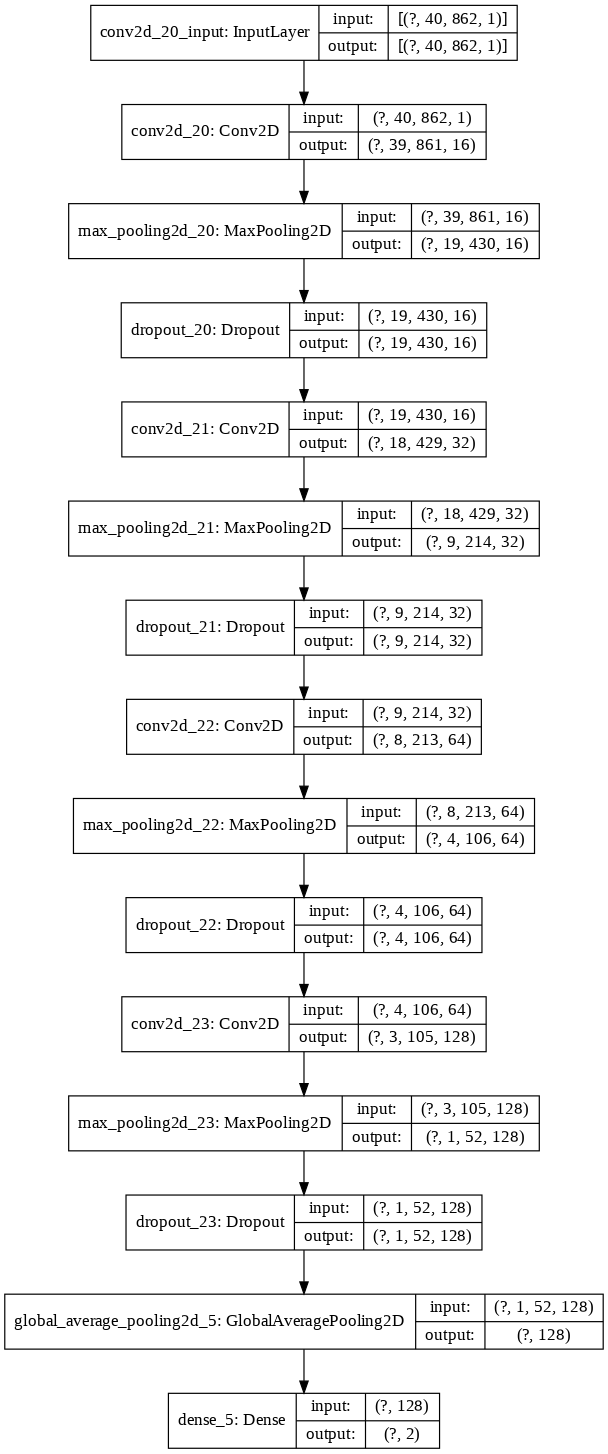

In [ ]:
tf.keras.utils.plot_model(
      feature_models['mfcc'],
      to_file='{}.png'.format(model.name),
      show_shapes=True,
      show_layer_names=True,
      rankdir='TB',
      expand_nested=False,
      dpi=86
)

### Pre-train accuracy (Individual Features)


In [ ]:
model_weights = feature_models['mfcc'].get_weights()

In [ ]:
# feature_models['mfcc'].save_weights("extraop_weights.h5")
    

In [ ]:
pre_train_accuracies_individual = {}



for feature_name in tqdm(feature_names, desc="Individual Features"):
    model = feature_models[feature_name]

    model.set_weights(model_weights)

    print("------- Model for: {} -------".format(model.name))
        # model.summary()

    #   print(x_tests[feature_name].shape)
    #   print(y_tests[feature_name].shape)

    # Calculate pre-training accuracy 
    score = model.evaluate(x_tests[feature_name], y_tests[feature_name], verbose=0)
    accuracy = 100 * score[1]

    pre_train_accuracies_individual[feature_name] = accuracy

    print("Pre-training accuracy: %.4f%%\n" % accuracy)

------- Model for: mfcc -------
Pre-training accuracy: 31.6206%

------- Model for: melspectrogram -------
Pre-training accuracy: 31.6206%

------- Model for: chroma_stft -------
Pre-training accuracy: 31.6206%

------- Model for: chroma_cqt -------
Pre-training accuracy: 31.6206%

------- Model for: chroma_cens -------
Pre-training accuracy: 31.6206%




### Pre-train accuracy (Folded)


In [ ]:
# def load_kfold_features(feature_name, index, name):
#     KFOLD_SAVE_PATH_ROOT = "kfold_data"
    
#     index_root = "{root}/{feature}/{index}".format(root=KFOLD_SAVE_PATH_ROOT, feature=feature_name, index=index)
    
#     return np.load(os.path.join(index_root, name + ".npy"))

In [ ]:
# pre_train_accuracies_folded = {}

# for feature_name in tqdm(feature_names, desc="KFold Progress Overall"):
#     print("Scoring KFold - {}".format(feature_name))

#     pre_train_accuracies_folded[feature_name] = {}

#     for i in tqdm(range(kfold_splits)):
#         # print(i)

#         model = kfold_models[feature_name][i]
        
#         # X_test = folded_features[feature_name][i]['X_test']
#         # y_test = folded_features[feature_name][i]['y_test']

#         X_test = load_kfold_features(feature_name, index=i, name='X_test')
#         y_test = load_kfold_features(feature_name, index=i, name='y_test')

#         # y_test = np.reshape(y_test, (*y_test.shape,1)) 

#         # print(X_test.shape)
#         # print(y_test.shape)
        
#         score = model.evaluate(X_test, y_test, verbose=0, callbacks=[tfa.callbacks.TQDMProgressBar()])
#         accuracy = 100 * score[1]

#         pre_train_accuracies_folded[feature_name][i] = accuracy

#         # print("Fold - {}".format(i))
#         # print("Pre-training Accuracy: %.4f%%\n" % accuracy)

#     print("Accuracies Mean: %.4f%%\n" % np.mean(list(pre_train_accuracies_folded[feature_name].values())))

## Pretraining accuracy: Common Model 

In [ ]:
# common_model_pretrain_accuracy = 0

# score = model.evaluate(x_test_all, y_test_all, verbose=0, callbacks=[tfa.callbacks.TQDMProgressBar()])
# common_model_pretrain_accuracy = 100 * score[1]

# print("Common model pretrain: %.4f%%\n" % common_model_pretrain_accuracy)

### Train the model

In [ ]:
from datetime import datetime

num_epochs = 250
num_batch_size = 128

initial_weights = model_weights

# Histories object
histories = {}
training_times = {}

if os.path.exists('saved_models'):
    !rm -rf saved_models

for feature_name in tqdm(feature_names):

    feature_dir = "saved_models/{}".format(feature_name)

    if not os.path.exists(feature_dir):
        os.makedirs(feature_dir)

    callbacks = [
    ModelCheckpoint(
        filepath=feature_dir + "/" + feature_name + '_model_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
    ]


    print("Retrieving model.")
    model = feature_models[feature_name]

    print("Setting the same init weights for every model...")
    model.set_weights(initial_weights)

    print("-------- Training {} ----------".format(model.name))
    print("-------- Feature: {}".format(feature_name))

    start = datetime.now()

    history = model.fit(x_trains[feature_name], y_trains[feature_name], batch_size=num_batch_size, epochs=num_epochs,
            validation_data=(x_tests[feature_name], y_tests[feature_name]), callbacks=callbacks, verbose=1)

    histories[feature_name] = history

    duration = datetime.now() - start

    training_times[feature_name] = duration

    print("Training completed in time: {}".format(duration))

Streaming output truncated to the last 5000 lines.
7/7 [==============================] - 0s 49ms/step - loss: 0.5203 - accuracy: 0.8296 - val_loss: 0.7846 - val_accuracy: 0.6798
Epoch 7/250
7/7 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.8285
Epoch 00007: val_accuracy did not improve from 0.68379
7/7 [==============================] - 0s 50ms/step - loss: 0.4896 - accuracy: 0.8285 - val_loss: 0.7464 - val_accuracy: 0.6798
Epoch 8/250
7/7 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8318
Epoch 00008: val_accuracy did not improve from 0.68379
7/7 [==============================] - 0s 49ms/step - loss: 0.4486 - accuracy: 0.8318 - val_loss: 0.7024 - val_accuracy: 0.6818
Epoch 9/250
7/7 [==============================] - ETA: 0s - loss: 0.4666 - accuracy: 0.8397
Epoch 00009: val_accuracy did not improve from 0.68379
7/7 [==============================] - 0s 48ms/step - loss: 0.4666 - accuracy: 0.8397 - val_loss: 0.5954 - val_accuracy: 

In [ ]:
# num_epochs = 250
# num_batch_size = 128

# kfold_histories = {}
# kfold_training_times = {}

# for feature_name in tqdm(feature_names, desc="KFold Training Overall"):

#     feature_dir_fold = "kfold_models/{}".format(feature_name)

#     # Create dir to store the models
#     if not os.path.exists(feature_dir_folded):
        
#         print("Folded {} doesn't exist. Creating.".format(feature_dir_fold))
#         os.makedirs(feature_dir_folded)
    
#     kfold_histories[feature_name] = {}
#     kfold_training_times[feature_name] = {}

#     for i in tqdm(range(kfold_splits)):
#         print("Training KFold - {} [{}]".format(feature_name, i))

#         fold_dir = "{}/{}".format(feature_dir_fold, i)

#         # Create dir to store the models
#         if not os.path.exists(fold_dir):
            
#             print("Folded {} doesn't exist. Creating.".format(fold_dir))
#             os.makedirs(fold_dir)

#         callbacks = [
#             ModelCheckpoint(
#                 filepath=fold_dir + "/" + feature_name + "_" + "_model_{epoch:02d}.h5",
#                 # Path where to save the model
#                 # The two parameters below mean that we will overwrite
#                 # the current checkpoint if and only if
#                 # the `val_accuracy` score has improved.
#                 save_best_only=True,
#                 monitor='val_accuracy',
#                 verbose=1)
#         ]

#         model = kfold_models[feature_name][i]

#         print("Loading features...")
        
#         X_train = load_kfold_features(feature_name, i, 'X_train')
#         y_train = load_kfold_features(feature_name, i, 'y_train')
#         X_test  = load_kfold_features(feature_name, i, 'X_test')
#         y_test  = load_kfold_features(feature_name, i, 'y_test')

#         start = datetime.now()

#         print("Training...")

#         history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
#           validation_data=(X_test, y_test), callbacks=callbacks, verbose=1, multiprocessing=True)

#         kfold_histories[feature_name][i] = history

#         duration = datetime.now() - start

#         kfold_training_times[feature_name][i] = duration

## Model Analysis

### Individual Features

In [ ]:
# Print out the accuracies of all.
accuracies = {}
losses = {}

print("Individial Features-")
print("feature,acc,loss")

for name in feature_names:
  print("{},{},{}".format(name, np.mean(histories[name].history['accuracy']) * 100, np.mean(histories[name].history['loss']) * 100))
  accuracies[name] = np.mean(histories[name].history['accuracy']) * 100
  losses[name] = np.mean(histories[name].history['loss']) * 100

Individial Features-
feature,acc,loss
mfcc,95.3165918827057,14.336217194795609
melspectrogram,83.63363230228424,36.67765634059906
chroma_stft,86.49013448953629,32.01191343069076
chroma_cqt,77.26143507957458,46.00008528232574
chroma_cens,80.34573981761932,41.25077378153801


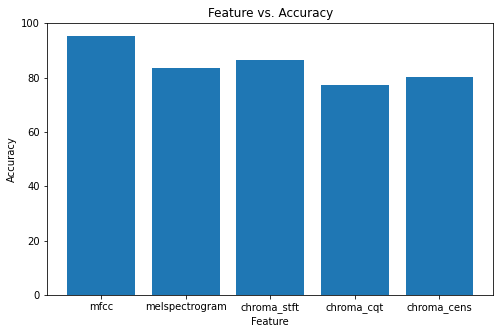

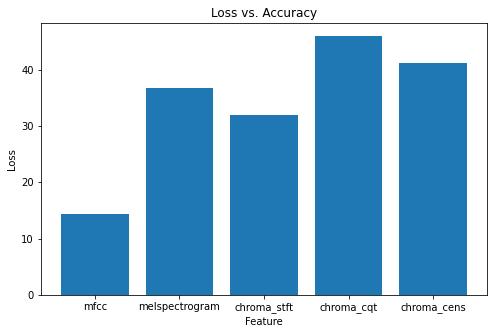

In [ ]:
# Comparision of accuracies of all folds for each feature
feature_names_extracted = list(accuracies.keys())
accuracies_extracted = list(accuracies.values())

plt.figure(figsize=(8, 5)) 
plt.bar(range(len(accuracies)),accuracies_extracted, tick_label = feature_names_extracted)
plt.xlabel("Feature")
plt.ylabel("Accuracy")
plt.title("Feature vs. Accuracy")

plt.show()

feature_names_extracted = list(losses.keys())
losses_extracted = list(losses.values())


plt.figure(figsize=(8, 5)) 
plt.bar(range(len(losses)), losses_extracted, tick_label = feature_names_extracted)
plt.xlabel("Feature")
plt.ylabel("Loss")
plt.title("Loss vs. Accuracy")

plt.show()

### Folded Features

In [ ]:
# # Print out the accuracies of all.
# folded_accuracies_all = {}
# folded_losses_all = {}

# print("Folded-")


# for name in feature_names:
#     folded_accuracies_all[name] = {}
#     folded_losses_all[name]     = {}

#     print()

#     print("feature,fold,acc,loss")
#     for i in range(kfold_splits):
#         history = kfold_histories[feature_name][i]

#         print("{},{},{},{}".format(name,
#                                    i, 
#                                    np.mean(history.history['accuracy']) * 100, 
#                                    np.mean(history.history['loss']) * 100))
        
#         # Store mean of acc and loss of all the 250 epochs
#         folded_accuracies_all[name][i] = np.mean(history.history['accuracy']) * 100
#         folded_losses_all[name][i]     = np.mean(history.history['loss'])     * 100

In [ ]:
# # Comparision of accuracies of each fold for all features
# for feature in feature_names:

#     print("Feature: {}".format(feature))

#     fold_accuracies = list(folded_accuracies_all[name].values())
#     fold_indices = list(folded_accuracies_all[name].keys())

#     plt.figure(figsize=(8, 5)) 
#     plt.bar(range(len(fold_indices)), fold_accuracies, tick_label = fold_indices)
#     plt.xlabel("Fold Index")
#     plt.ylabel("Accuracy")
#     plt.title("Fold index vs. Accuracy [{}]".format(feature))

#     plt.show()

#     fold_losses = list(folded_losses_all[name].values())
#     fold_indices = list(folded_losses_all[name].keys())

#     plt.figure(figsize=(8, 5)) 
#     plt.bar(range(len(fold_indices)), fold_losses, tick_label = fold_indices)
#     plt.xlabel("Fold Index")
#     plt.ylabel("Loss")
#     plt.title("Fold Index vs. Loss [{}]".format(feature))

#     plt.show()

In [ ]:
# # Calculation of mean of accuracies/losses (folds) for each feature
# folded_mean_acc  = {}
# folded_mean_loss = {}

# for feature in feature_names:
#     fold_accuracies = list(folded_accuracies_all[name].values())
#     fold_losses = list(folded_losses_all[name].values())

#     folded_mean_acc[feature]  = np.mean(fold_accuracies)
#     folded_mean_loss[feature] = np.mean(fold_losses)

# print("Average Folded Accuracies:")
# print("--------------------------")
# print("feature,acc")
# for feature in feature_names:
#     print("{},{}".format(feature, folded_mean_acc[feature]))

# print()

# print("Average Folded Losses")
# print("--------------------------")
# print("feature,loss")
# for feature in feature_names:
#     print("{},{}".format(feature, folded_mean_loss[feature]))

In [ ]:
# # Comparision of mean of accuracies/losses (folds) for each feature
# fold_accuracies = list(folded_mean_acc.values())
# feature_names = list(folded_mean_acc.keys())

# plt.figure(figsize=(8, 5)) 
# plt.bar(range(len(feature_names)), fold_accuracies, tick_label = feature_names)
# plt.xlabel("Features")
# plt.ylabel("Mean Accuracy")
# plt.title("Feature vs. Mean Accuracy [{}]".format(feature))

# plt.show()

# fold_losses = list(folded_mean_loss.values())
# feature_names = list(folded_mean_loss.keys())

# plt.figure(figsize=(8, 5)) 
# plt.bar(range(len(feature_names)), fold_losses, tick_label = feature_names)
# plt.xlabel("Features")
# plt.ylabel("Mean Loss")
# plt.title("Feature vs. Mean Loss [{}]".format(feature))

# plt.show()

### Visualize Model

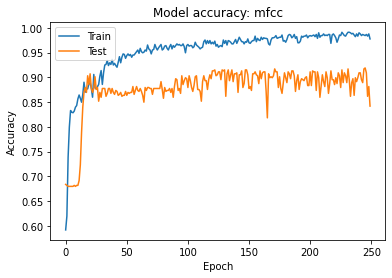

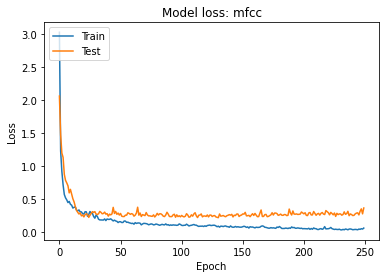

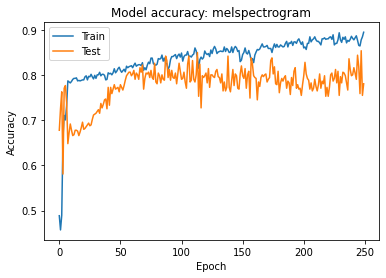

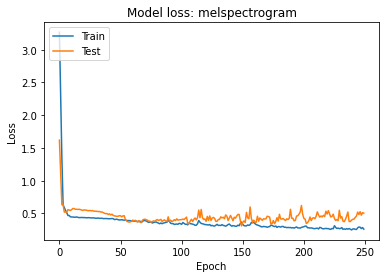

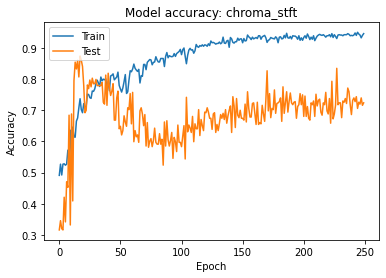

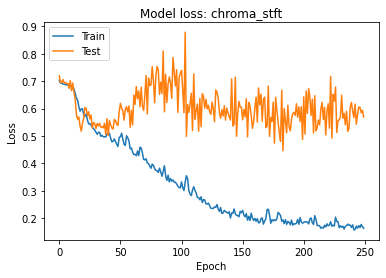

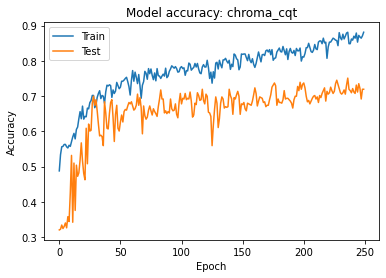

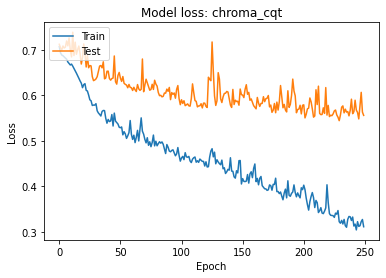

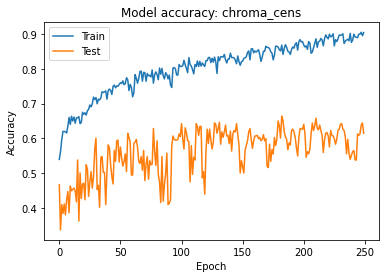

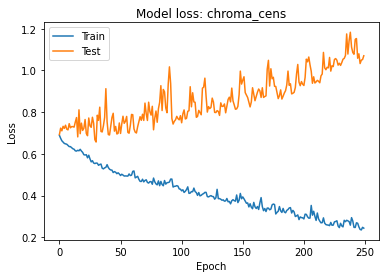

In [ ]:
# Plot the history plots for all the history objects in 'histories'. Access them with histories[feature_name]

for feature_name in feature_names:
    history = histories[feature_name]

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy: {}'.format(feature_name))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss: {}'.format(feature_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

### Test the model (Individual Features)
Test the model's accuracy on both `training` and `test` sets.

In [ ]:
# Evaluating the model on the training and testing set
# TODO: Evaluate all the models here.
training_accuracies_post = {}
testing_accuracies_post = {}

if not os.path.exists('metric_csvs'):
    os.makedirs('metric_csvs')

print("PTA Training Acc")
print("feature,pta_train_acc")
for feature_name in feature_names:
    model = feature_models[feature_name]

    training_score = model.evaluate(x_trains[feature_name], y_trains[feature_name], verbose=0)
    print("{},{}".format(feature_name, training_score[1] * 100))

    training_accuracies_post[feature_name] = training_score[1] * 100


print()
print("PTA Testing Acc")
print("feature,pta_test_acc")
for feature_name in feature_names:
    model = feature_models[feature_name]
    
    testing_score = model.evaluate(x_tests[feature_name], y_tests[feature_name], verbose=0)
    
    print("{},{}".format(feature_name, testing_score[1] * 100))
    testing_accuracies_post[feature_name] = testing_score[1] * 100

df_training_accuracies_post = pd.DataFrame({'feature': list(training_accuracies_post.keys()), "pta_train_acc": list(training_accuracies_post.values())}, columns=['feature', 'pta_train_acc'])
df_testing_accuracies_post = pd.DataFrame({'feature': list(testing_accuracies_post.keys()), "pta_test_acc": list(testing_accuracies_post.values())}, columns=['feature', 'pta_test_acc'])

df_training_accuracies_post.to_csv('metric_csvs/{}_pta_train_acc.csv'.format('postaug' if augment else 'preaug'))
df_testing_accuracies_post.to_csv('metric_csvs/{}_pta_test_acc.csv'.format('postaug' if augment else 'preaug'))

PTA Training Acc
feature,pta_train_acc
mfcc,82.3991060256958
melspectrogram,88.90134692192078
chroma_stft,74.10314083099365
chroma_cqt,91.36771559715271
chroma_cens,90.8071756362915

PTA Testing Acc
feature,pta_test_acc
mfcc,84.18972492218018
melspectrogram,78.06324362754822
chroma_stft,72.33201861381531
chroma_cqt,71.93675637245178
chroma_cens,61.46245002746582


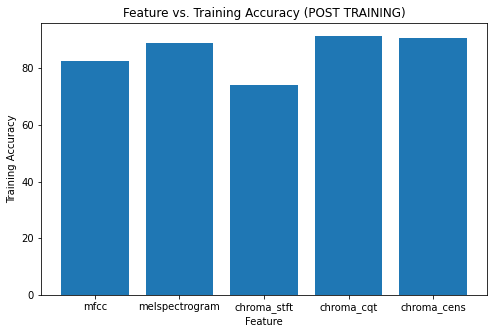

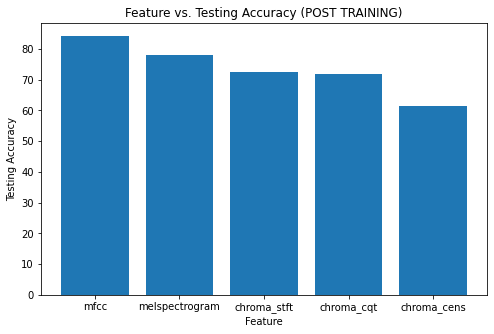

In [ ]:
training_accuracies_post_labels = list(training_accuracies_post.keys())
training_accuracies_post_extracted = list(training_accuracies_post.values())

testing_accuracies_post_labels = list(testing_accuracies_post.keys())
testing_accuracies_post_extracted = list(testing_accuracies_post.values())

plt.figure(figsize=(8, 5)) 
plt.bar(range(len(training_accuracies_post)), training_accuracies_post_extracted, tick_label = training_accuracies_post_labels)
plt.xlabel("Feature")
plt.ylabel("Training Accuracy")
plt.title("Feature vs. Training Accuracy (POST TRAINING)")

plt.show()

plt.figure(figsize=(8, 5)) 
plt.bar(range(len(testing_accuracies_post)), testing_accuracies_post_extracted, tick_label = testing_accuracies_post_labels)
plt.xlabel("Feature")
plt.ylabel("Testing Accuracy")
plt.title("Feature vs. Testing Accuracy (POST TRAINING)")

plt.show()

## Testing Model (KFold Models)
Test each folded model on the specific `training` and `testing` sets.

In [ ]:
# post_test_accuracies_folded  = {}
# post_train_accuracies_folded = {}


# for feature_name in tqdm(feature_names, desc="KFold Progress Overall"):
#     print("Scoring KFold - {}".format(feature_name))

#     post_train_accuracies_folded[feature_name] = {}

#     for i in tqdm(range(kfold_splits)):
#         # print(i)

#         model = kfold_models[feature_name][i]

#         X_train = load_kfold_features(feature_name, index=i, name='X_train')
#         y_train = load_kfold_features(feature_name, index=i, name='y_train')

#         score = model.evaluate(X_test, y_test, verbose=0)
#         accuracy = 100 * score[1]

#         post_train_accuracies_folded[feature_name][i] = accuracy


#     mean_accuracies = np.mean(list(post_train_accuracies_folded[feature_name].values()))


# for feature_name in tqdm(feature_names, desc="KFold Progress Overall"):
#     print("Scoring KFold - {}".format(feature_name))

#     post_test_accuracies_folded[feature_name] = {}

#     for i in tqdm(range(kfold_splits)):
#         # print(i)

#         model = kfold_models[feature_name][i]

#         X_test = load_kfold_features(feature_name, index=i, name='X_test')
#         y_test = load_kfold_features(feature_name, index=i, name='y_test')

#         score = model.evaluate(X_test, y_test, verbose=0)
#         accuracy = 100 * score[1]

#         post_test_accuracies_folded[feature_name][i] = accuracy


#     mean_accuracies = np.mean(list(post_test_accuracies_folded[feature_name].values()))

In [ ]:
# print("feature,index,pta_training_folded")
# for feature in feature_names:
#     for i in range(kfold_splits)
#         print("{},{},{}".format(feature, i, post_train_accuracies_folded[feature_name][i]))


# print()

# print("feature,index,pta_testing_folded")
# for feature in feature_names:
#     for i in range(kfold_splits)
#         print("{},{},{}".format(feature, i, post_test_accuracies_folded[feature_name][i]))


### Classification Report

------ Model Name: mfcc -------
              precision    recall  f1-score   support

        COPD       0.94      0.97      0.96       346
    non-COPD       0.93      0.88      0.90       160

    accuracy                           0.94       506
   macro avg       0.94      0.92      0.93       506
weighted avg       0.94      0.94      0.94       506



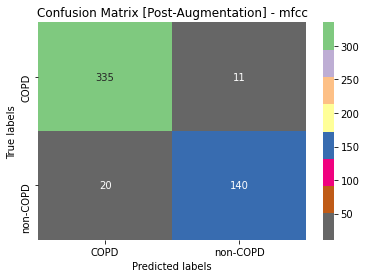

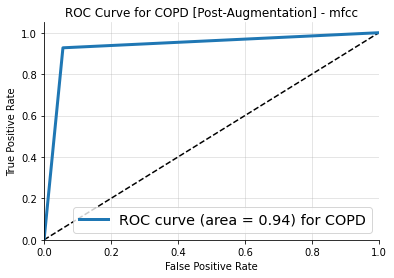

------ Model Name: melspectrogram -------
              precision    recall  f1-score   support

        COPD       0.94      0.72      0.82       346
    non-COPD       0.60      0.91      0.72       160

    accuracy                           0.78       506
   macro avg       0.77      0.81      0.77       506
weighted avg       0.84      0.78      0.79       506



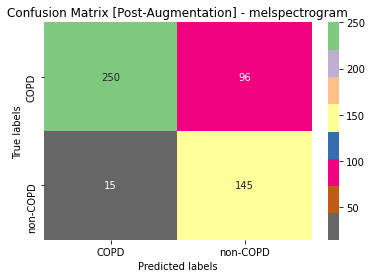

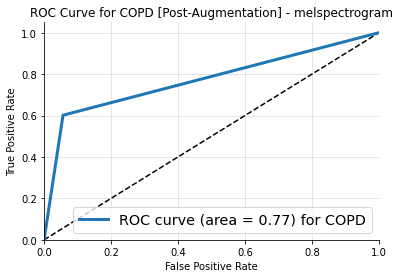

------ Model Name: chroma_stft -------
              precision    recall  f1-score   support

        COPD       0.74      0.91      0.82       346
    non-COPD       0.62      0.31      0.42       160

    accuracy                           0.72       506
   macro avg       0.68      0.61      0.62       506
weighted avg       0.70      0.72      0.69       506



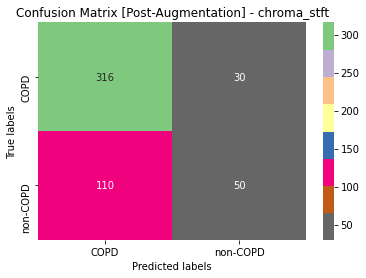

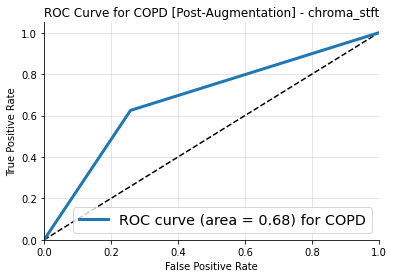

------ Model Name: chroma_cqt -------
              precision    recall  f1-score   support

        COPD       0.79      0.81      0.80       346
    non-COPD       0.56      0.53      0.54       160

    accuracy                           0.72       506
   macro avg       0.67      0.67      0.67       506
weighted avg       0.72      0.72      0.72       506



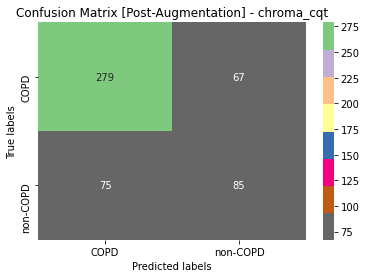

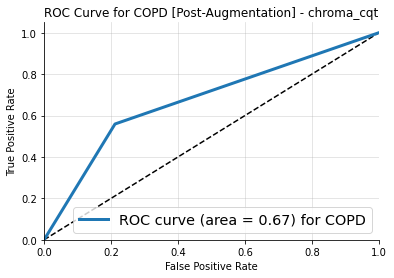

------ Model Name: chroma_cens -------
              precision    recall  f1-score   support

        COPD       0.74      0.68      0.71       346
    non-COPD       0.41      0.47      0.43       160

    accuracy                           0.61       506
   macro avg       0.57      0.58      0.57       506
weighted avg       0.63      0.61      0.62       506



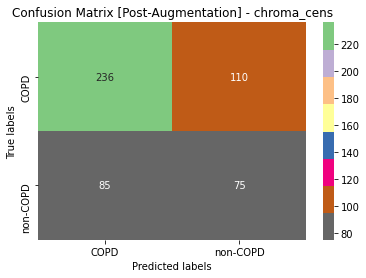

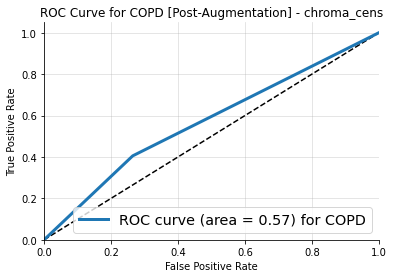

In [ ]:
import seaborn as sns
from sklearn.metrics import auc, plot_confusion_matrix

auc_features = {}

if not os.path.exists('cm'):
    os.makedirs('cm')
    
if not os.path.exists('roc'):
    os.makedirs('roc')


for feature_name in feature_names:
    model = feature_models[feature_name]

    print("------ Model Name: {} -------".format(model.name))

    # Use the model to predict on the test-set
    test_predictions = model.predict(x_tests[feature_name])
    # print(test_predictions)

    # Calculate classes from the predictions
    class_predictions = np.argmax(test_predictions, axis=1)
    # # print(class_predictions)

    # Actual classes in the test-set
    class_actual = np.argmax(y_tests[feature_name], axis=1) # true classes

    # No. of classes
    n_classes = 2

    # Classes
    class_names = ['COPD', 'non-COPD']

    # Classification Report
    print(classification_report(class_actual, class_predictions, target_names=class_names))

    # Generate the confusion matrix
    cm = confusion_matrix(class_actual, class_predictions)

    # print(cm)
    cm_title = 'Confusion Matrix [{}-Augmentation] - {}'.format('Post' if augment else 'Pre', feature_name)

    # Print it using a utility function
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Accent_r'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(cm_title); 
    ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
    plt.savefig('cm/' + cm_title)


    # ROC Curve
    fpr, tpr, t = roc_curve(np.argmax(test_predictions, axis=-1), np.argmax(y_tests[feature_name], axis=-1))
    roc_auc = auc(fpr, tpr)


    # Add AUC to dict
    auc_features[feature_name] = roc_auc

    # print("Threshold %", t)
    roc_title = 'ROC Curve for COPD [{}-Augmentation] - {}'.format('Post' if augment else 'Pre',feature_name)

    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(roc_title)
    ax.plot(fpr, tpr, linewidth=3, label='ROC curve (area = %0.2f) for COPD' % (roc_auc))
    ax.legend(loc="lower right", fontsize='x-large')
    ax.grid(alpha=.4)
    sns.despine()
    plt.savefig('roc/' + roc_title)
    plt.show()


In [ ]:
# Metrics for all models (Individual features)
# del feature

metrics_columns = ['feature', 'senstivity', 'specificity', 'auc', 'icbhi score']


metrics_dict = []

print(",".join(metrics_columns))

for feature_name in feature_names:
    model = feature_models[feature_name]

    # Use the model to predict on the test-set
    test_predictions = model.predict(x_tests[feature_name])
    # print(test_predictions)

    # Calculate classes from the predictions
    class_predictions = np.argmax(test_predictions, axis=1)
    # # print(class_predictions)

    # Actual classes in the test-set
    class_actual = np.argmax(y_tests[feature_name], axis=1) # true classes

    # Generate the confusion matrix
    cm = confusion_matrix(class_actual, class_predictions)

    TP = cm[0][0]
    FN = cm[0][1]
    FP = cm[1][0]
    TN = cm[1][1]

    senstivity = TP/(TP+FN) # Recall
    specificity = TN/(TN+FP)
    precision = TP/(TP+FP)
    auc_ = auc_features[feature_name]
    icbhi_score= (senstivity + specificity) / 2

    print("{},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}".format(feature_name,senstivity,specificity,precision,auc_, icbhi_score))

    metrics_dict.append({
        'feature': feature_name,
        'senstivity': senstivity,
        'specificity': specificity,
        'precision': precision,
        'auc': auc_,
        'icbhi score': icbhi_score
    })

metrics_final_scores = pd.DataFrame(metrics_dict, columns=metrics_columns)

metrics_final_scores.to_csv('metric_csvs/{}_metrics.csv'.format('postaug' if augment else 'preaug'))

feature,senstivity,specificity,auc,icbhi score
mfcc,0.97,0.88,0.94,0.94,0.92
melspectrogram,0.72,0.91,0.94,0.77,0.81
chroma_stft,0.91,0.31,0.74,0.68,0.61
chroma_cqt,0.81,0.53,0.79,0.67,0.67
chroma_cens,0.68,0.47,0.74,0.57,0.58


## Download Graphs in a Zip File

In [ ]:
import time
filename_results = 'output_{}'.format(time.strftime("%Y%m%d-%H%M%S"))

!zip -r {filename_results}.zip ./cm
!zip -r {filename_results}.zip ./roc
!zip -r {filename_results}.zip ./metric_csvs

from google.colab import files
files.download('{}.zip'.format(filename_results))
# files.download('roc.zip')

  adding: cm/ (stored 0%)
  adding: cm/Confusion Matrix [Post-Augmentation] - chroma_cqt.png (deflated 10%)
  adding: cm/Confusion Matrix [Pre-Augmentation] - mfcc.png (deflated 11%)
  adding: cm/Confusion Matrix [Post-Augmentation] - melspectrogram.png (deflated 10%)
  adding: cm/Confusion Matrix [Pre-Augmentation] - melspectrogram.png (deflated 10%)
  adding: cm/Confusion Matrix [Post-Augmentation] - chroma_stft.png (deflated 10%)
  adding: cm/Confusion Matrix [Post-Augmentation] - mfcc.png (deflated 10%)
  adding: cm/Confusion Matrix [Pre-Augmentation] - chroma_stft.png (deflated 10%)
  adding: cm/Confusion Matrix [Post-Augmentation] - chroma_cens.png (deflated 10%)
  adding: cm/Confusion Matrix [Pre-Augmentation] - chroma_cens.png (deflated 11%)
  adding: cm/Confusion Matrix [Pre-Augmentation] - chroma_cqt.png (deflated 11%)
  adding: roc/ (stored 0%)
  adding: roc/ROC Curve for COPD [Pre-Augmentation] - melspectrogram.png (deflated 7%)
  adding: roc/ROC Curve for COPD [Pre-Augment

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Backup models to drive

In [ ]:
backup_dirs = ['saved_models']

augment_model_dir = "aug" if augment else "noaug"

for directory in backup_dirs:
    print("Copying dir {}".format(directory))
    !rm -rf drive/My\ Drive/CNN_Detection/model_backups/{augment_model_dir}/{directory}

    if not os.path.exists("drive/My Drive/CNN_Detection/model_backups/{}/{}".format(augment_model_dir, directory)):
        os.makedirs("drive/My Drive/CNN_Detection/model_backups/{}/{}".format(augment_model_dir, directory))

    !cp -r {directory} drive/My\ Drive/CNN_Detection/model_backups/{augment_model_dir}

In [ ]:
MFCC = 'mfcc'
C_CENS = 'c_cens'
MEL = 'mel'
C_CQT = 'c_cqt'
C_STFT = 'c_stft'

feature_model_dirs = {
    MFCC: 'mfcc',
    C_CENS: 'chroma_cens',
    MEL: 'melspectrogram',
    C_CQT: 'chroma_cqt',
    C_STFT: 'chroma_stft'
}


In [ ]:
import logging
from tensorflow.keras.models import load_model

def load_model_from_file(type=None):
    model_dir = '/content/drive/My Drive/CNN_Detection/model_backups/aug/saved_models'

    if type not in [MFCC, C_CENS, MEL, C_CQT, C_STFT]:
        raise Exception("Invalid type.")

    concerned_dir = os.path.join(model_dir, feature_model_dirs[type])

    dir_contents = os.listdir(concerned_dir)

    if len(dir_contents) == 0:
        raise Exception("No model found in {}".format(concerned_dir))

    model_numbers = [int(name.split(".")[0].split("_")[2]) for name in dir_contents]

    model_name = feature_model_dirs[type] + "_" + "model_" + str(sorted(model_numbers)[-1]) + ".h5"

    # list_dir = [f.lower() for f in dir_contents]   # Convert to lower case
    
    print('Found best model "{}" for type: {}'.format(model_name, feature_model_dirs[type]))

    model_path = os.path.join(concerned_dir, model_name)

    print(logging.DEBUG, "Loading {} model...".format(type))
    model = load_model(model_path)

    return model

In [ ]:
import os

mfcc_model = load_model_from_file(MFCC)
mel_model = load_model_from_file(MEL)
chroma_cens_model = load_model_from_file(C_CENS)
chroma_cqt_model = load_model_from_file(C_CQT)
chroma_stft_model = load_model_from_file(C_STFT)

Found best model "mfcc_model_77.h5" for type: mfcc
10 Loading mfcc model...
Found best model "melspectrogram_model_190.h5" for type: melspectrogram
10 Loading mel model...


ValueError: ignored

In [ ]:
feature_models['mfcc'] = mfcc_model